# Обучение моделей в Pytorch

In [18]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree

import albumentations
import numpy as np
import torch
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from dataset import CustomDataset
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from train import (
    CheckpointSaver,
    load_checkpoint,
    train,
)
from unet import UNet
from Metric import MeanIoU
from Loss import DiceLoss

In [19]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

## Аугментации

In [20]:
IMAGE_SIZE = 256
transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        ToTensorV2(),
    ]
)

## Dataset

In [21]:
train_dataset = CustomDataset(root_dir="C:/Segmentation",transforms = transforms)
val_dataset = CustomDataset(root_dir="C:/Segmentation",transforms = transforms)
len(train_dataset)


253

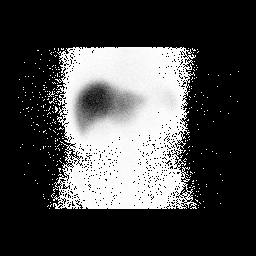

In [22]:
from torchvision.transforms.functional import to_pil_image
img, msk = train_dataset[0]
image = to_pil_image(img)
mask = to_pil_image(msk)
image

In [23]:
img.shape

torch.Size([3, 256, 256])

In [24]:
msk.shape

torch.Size([1, 256, 256])

## Accelerator

In [25]:
accelerator = Accelerator(cpu=False, mixed_precision="fp16")

## Обучаем модель

In [26]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
EPOCH_NUM = 20
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

model = UNet(in_channels=3, out_channels=1)

loss_fn = DiceLoss()
metric_fn = MeanIoU()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=5, gamma=0.8
)

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="DICE",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)

In [28]:
# !pip install tensorboard
# tensorboard_logger = None

os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [29]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

In [ ]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------
Epoch 0/20


Training:   0%|          | 0/64 [00:00<?, ?it/s]

## Загрузим и протестируем обученную модель

In [ ]:
model = UNet(in_channels=3, out_channels=1)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval()

In [ ]:
sample_idx = 1
image, target = train_dataset[sample_idx]
thresold = 0.8
preds = F.sigmoid(model(image.unsqueeze(0).to(DEVICE))).squeeze(0)
binary_preds = (preds > thresold)
fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[1].imshow(target.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[2].imshow(binary_preds.cpu().numpy()[0]);